<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/Copy_of_Govindan_Wilson_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from itertools import combinations
import random

=== Govindan-Wilson Algorithm Demonstration ===

=== Prisoner's Dilemma Example ===
Starting Govindan-Wilson algorithm...
Stalled at t=0.9999999999999999
Nash equilibrium found: True
Epsilon values: Player 1 = 0.00000000, Player 2 = 0.00000000

Equilibrium strategies:
Player 1: [0. 1.]
Player 2: [0. 1.]


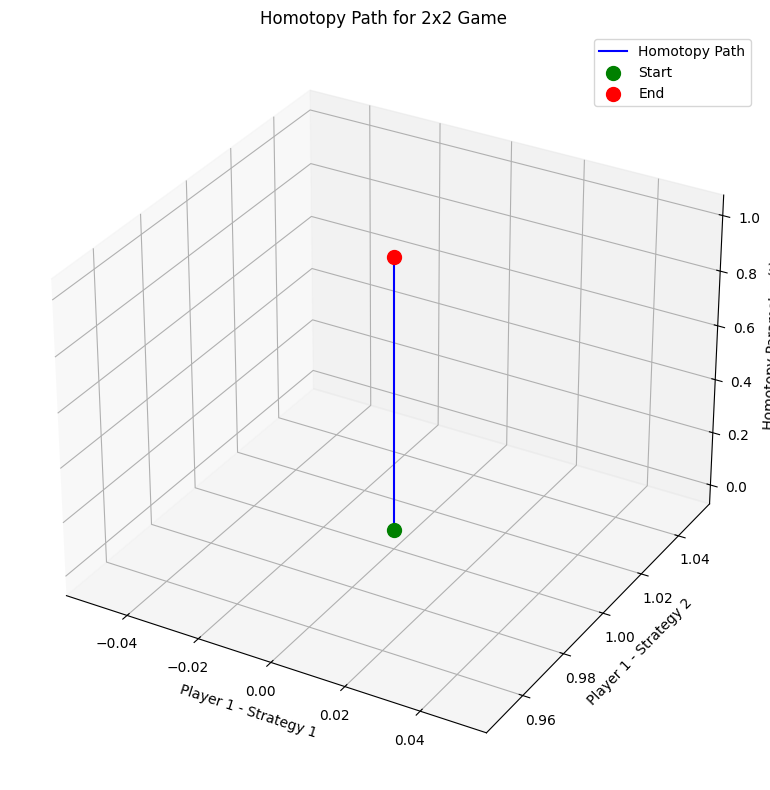


Theoretical equilibrium:
Player 1: [0, 1] (Defect)
Player 2: [0, 1] (Defect)

=== Battle of the Sexes Example ===
Starting Govindan-Wilson algorithm...
Stalled at t=0.9999999999999999
Nash equilibrium found: True
Epsilon values: Player 1 = 0.00000000, Player 2 = 0.00000000

Equilibrium strategies:
Player 1: [1. 0.]
Player 2: [1. 0.]


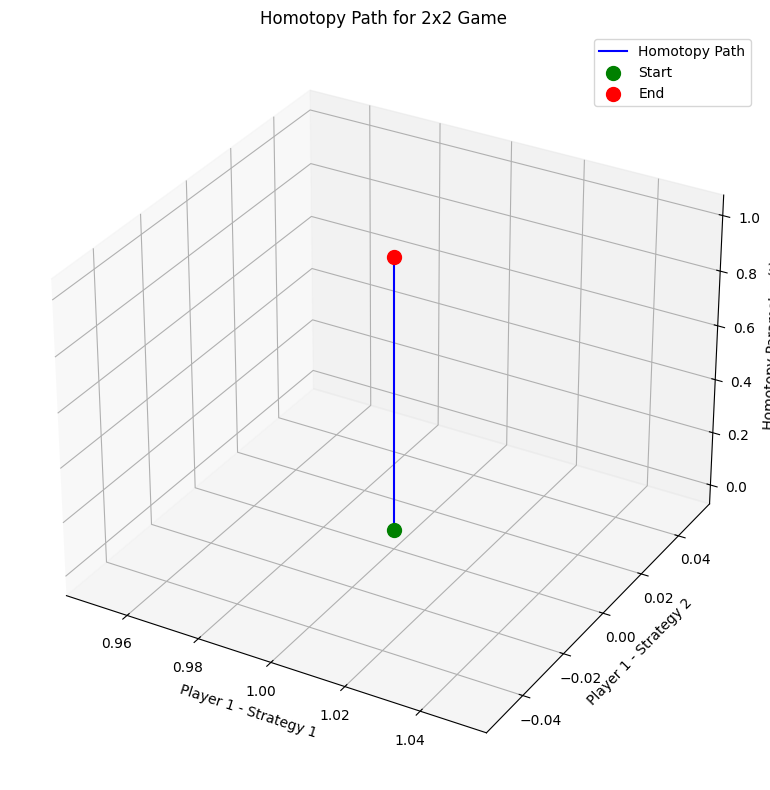


Theoretical mixed equilibrium:
Player 1: [0.6, 0.4] (0.6 probability of Opera, 0.4 probability of Football)
Player 2: [0.4, 0.6] (0.4 probability of Opera, 0.6 probability of Football)

=== Rock-Paper-Scissors Example ===
Starting Govindan-Wilson algorithm...
Stalled at t=0.9999999999999999
Nash equilibrium found: True
Epsilon values: Player 1 = 0.00000000, Player 2 = 0.00000000

Equilibrium strategies:
Player 1: [0.33333333 0.33333333 0.33333333]
Player 2: [0.33333333 0.33333333 0.33333333]


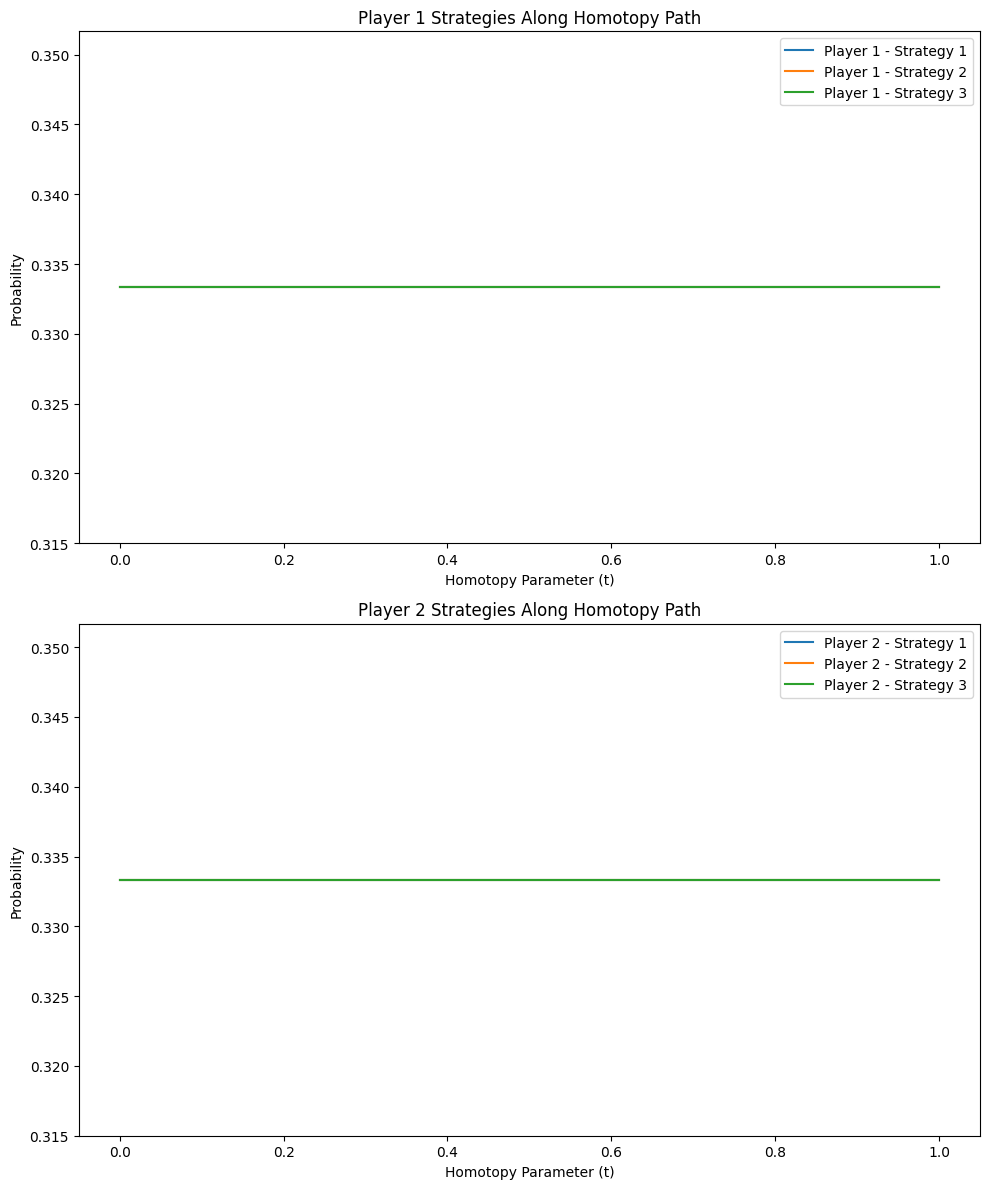


Theoretical equilibrium:
Player 1: [1/3, 1/3, 1/3]
Player 2: [1/3, 1/3, 1/3]


In [ ]:


class GovidanWilson:
    def __init__(self, A, B, epsilon=1e-8):
        """
        Initialize the Govindan-Wilson algorithm solver.

        Parameters:
        ----------
        A : numpy.ndarray
            Payoff matrix for player 1
        B : numpy.ndarray
            Payoff matrix for player 2
        epsilon : float
            Small constant for numerical stability
        """
        self.A = np.array(A, dtype=float)
        self.B = np.array(B, dtype=float)
        self.epsilon = epsilon

        # Validate dimensions
        if self.A.shape != self.B.shape:
            raise ValueError("Payoff matrices must have the same dimensions")

        self.m, self.n = self.A.shape  # m strategies for player 1, n for player 2

    def compute_best_response(self, strategy, player):
        """
        Compute the best response strategies for a given player.

        Parameters:
        ----------
        strategy : numpy.ndarray
            The strategy of the opponent
        player : int
            Player index (0 for player 1, 1 for player 2)

        Returns:
        -------
        numpy.ndarray
            The best response strategy
        """
        if player == 0:  # Player 1 best response to player 2's strategy
            expected_payoffs = np.dot(self.A, strategy)
            best_actions = np.where(np.isclose(expected_payoffs, np.max(expected_payoffs), atol=self.epsilon))[0]
        else:  # Player 2 best response to player 1's strategy
            expected_payoffs = np.dot(self.B.T, strategy)
            best_actions = np.where(np.isclose(expected_payoffs, np.max(expected_payoffs), atol=self.epsilon))[0]

        # Return mixed strategy that puts equal weight on all best responses
        best_response = np.zeros(self.n if player == 0 else self.m)
        best_response[best_actions] = 1.0 / len(best_actions)
        return best_response

    def create_homotopy_function(self, t, strategy1, strategy2):
        """
        Create the homotopy function H(x, t) that interpolates between
        a starting game and the target game.

        Parameters:
        ----------
        t : float
            Homotopy parameter between 0 and 1
        strategy1 : numpy.ndarray
            Current strategy for player 1
        strategy2 : numpy.ndarray
            Current strategy for player 2

        Returns:
        -------
        numpy.ndarray
            Value of the homotopy function
        """
        # For player 1: compute expected payoff and best response
        expected_payoff1 = np.dot(strategy1, np.dot(self.A, strategy2))
        best_response1 = self.compute_best_response(strategy2, 0)

        # For player 2: compute expected payoff and best response
        expected_payoff2 = np.dot(strategy2, np.dot(self.B.T, strategy1))
        best_response2 = self.compute_best_response(strategy1, 1)

        # Compute regret for each player (difference between best possible payoff and actual payoff)
        regret1 = np.dot(best_response1, np.dot(self.A, strategy2)) - expected_payoff1
        regret2 = np.dot(best_response2, np.dot(self.B.T, strategy1)) - expected_payoff2

        # Homotopy function combines current strategies with best responses based on parameter t
        H1 = (1-t) * (strategy1 - best_response1) + t * regret1
        H2 = (1-t) * (strategy2 - best_response2) + t * regret2

        return np.concatenate([H1, H2])

    def predictor_corrector_step(self, current_point, t, dt):
        """
        Perform a predictor-corrector step along the homotopy path.

        Parameters:
        ----------
        current_point : numpy.ndarray
            Current point on the path (strategy1, strategy2)
        t : float
            Current homotopy parameter
        dt : float
            Step size for the homotopy parameter

        Returns:
        -------
        tuple
            (next_point, t+dt) if successful, (None, t) if failed
        """
        strategy1 = current_point[:self.m]
        strategy2 = current_point[self.m:]

        # Calculate Jacobian matrix for the homotopy function
        J = self._calculate_jacobian(strategy1, strategy2, t)

        # Calculate tangent vector
        try:
            # Find nullspace of the Jacobian to get the tangent direction
            u, s, vh = np.linalg.svd(J)
            tangent = vh[-1]

            # Normalize tangent vector
            tangent = tangent / np.linalg.norm(tangent)

            # Ensure tangent points in the right direction (increasing t)
            if tangent[-1] < 0:
                tangent = -tangent

            # Predictor step (Euler step in tangent direction)
            predictor = current_point + dt * tangent[:-1] * (tangent[-1] / abs(tangent[-1]))

            # Project back to the simplex if needed
            predictor[:self.m] = self._project_to_simplex(predictor[:self.m])
            predictor[self.m:] = self._project_to_simplex(predictor[self.m:])

            # Corrector steps (Newton iterations)
            corrected = self._newton_corrector(predictor, t + dt)

            return corrected, t + dt

        except np.linalg.LinAlgError:
            print("Linear algebra error in predictor step")
            return None, t

    def _calculate_jacobian(self, strategy1, strategy2, t):
        """
        Calculate the Jacobian matrix of the homotopy function.

        Parameters:
        ----------
        strategy1 : numpy.ndarray
            Strategy for player 1
        strategy2 : numpy.ndarray
            Strategy for player 2
        t : float
            Homotopy parameter

        Returns:
        -------
        numpy.ndarray
            Jacobian matrix
        """
        # Initialize Jacobian matrix with zeros
        J = np.zeros((self.m + self.n, self.m + self.n + 1))

        # Calculate partial derivatives with respect to strategy1
        for i in range(self.m):
            perturbed = strategy1.copy()
            perturbed[i] += self.epsilon
            perturbed = self._project_to_simplex(perturbed)

            H_perturbed = self.create_homotopy_function(t, perturbed, strategy2)
            H_original = self.create_homotopy_function(t, strategy1, strategy2)

            J[:, i] = (H_perturbed - H_original) / self.epsilon

        # Calculate partial derivatives with respect to strategy2
        for j in range(self.n):
            perturbed = strategy2.copy()
            perturbed[j] += self.epsilon
            perturbed = self._project_to_simplex(perturbed)

            H_perturbed = self.create_homotopy_function(t, strategy1, perturbed)
            H_original = self.create_homotopy_function(t, strategy1, strategy2)

            J[:, self.m + j] = (H_perturbed - H_original) / self.epsilon

        # Calculate partial derivative with respect to t
        t_perturbed = t + self.epsilon
        H_perturbed = self.create_homotopy_function(t_perturbed, strategy1, strategy2)
        H_original = self.create_homotopy_function(t, strategy1, strategy2)

        J[:, -1] = (H_perturbed - H_original) / self.epsilon

        return J

    def _newton_corrector(self, predicted_point, t, max_iter=10):
        """
        Apply Newton's method to correct a predicted point.

        Parameters:
        ----------
        predicted_point : numpy.ndarray
            Predicted point from the predictor step
        t : float
            Current homotopy parameter
        max_iter : int
            Maximum number of Newton iterations

        Returns:
        -------
        numpy.ndarray
            Corrected point
        """
        current = predicted_point.copy()

        for _ in range(max_iter):
            strategy1 = current[:self.m]
            strategy2 = current[self.m:]

            # Evaluate homotopy function
            H = self.create_homotopy_function(t, strategy1, strategy2)

            # Check if we're close enough to zero
            if np.linalg.norm(H) < self.epsilon:
                break

            # Calculate Jacobian matrix (excluding t column)
            J = self._calculate_jacobian(strategy1, strategy2, t)[:, :-1]

            # Solve linear system to get Newton step
            try:
                # Use pseudoinverse for better stability
                J_pinv = np.linalg.pinv(J)
                step = -np.dot(J_pinv, H)

                # Update point
                current = current + step

                # Project back to simplex
                current[:self.m] = self._project_to_simplex(current[:self.m])
                current[self.m:] = self._project_to_simplex(current[self.m:])

            except np.linalg.LinAlgError:
                print("Linear algebra error in corrector step")
                break

        return current

    def _project_to_simplex(self, v):
        """
        Project a vector onto the probability simplex.

        Parameters:
        ----------
        v : numpy.ndarray
            Vector to project

        Returns:
        -------
        numpy.ndarray
            Projected vector
        """
        # Sort v in descending order
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u)

        # Find the index where the sum exceeds 1
        rho = np.nonzero(u * np.arange(1, len(v) + 1) > cssv - 1)[0]
        if len(rho) > 0:
            rho = rho[-1]
        else:
            rho = 0

        # Calculate the threshold
        theta = (cssv[rho] - 1) / (rho + 1)

        # Project using the threshold
        w = np.maximum(v - theta, 0)

        # Handle numerical issues
        if np.sum(w) == 0:
            w = np.ones_like(v) / len(v)
        else:
            w = w / np.sum(w)

        return w

    def find_starting_point(self):
        """
        Find a starting point for the homotopy path.

        Returns:
        -------
        numpy.ndarray
            Starting point (strategy1, strategy2)
        """
        # Start with uniform mixed strategies
        strategy1 = np.ones(self.m) / self.m
        strategy2 = np.ones(self.n) / self.n

        # Improve the starting point by iterating best responses
        for _ in range(10):
            strategy1 = self.compute_best_response(strategy2, 0)
            strategy2 = self.compute_best_response(strategy1, 1)

        return np.concatenate([strategy1, strategy2])

    def trace_path(self, max_steps=100, dt_init=0.1, dt_min=1e-3):
        """
        Trace the homotopy path from t=0 to t=1.

        Parameters:
        ----------
        max_steps : int
            Maximum number of steps along the path
        dt_init : float
            Initial step size
        dt_min : float
            Minimum step size

        Returns:
        -------
        numpy.ndarray
            Nash equilibrium strategies (strategy1, strategy2)
        """
        # Get starting point
        current_point = self.find_starting_point()
        t = 0.0
        dt = dt_init

        # Store path for visualization
        path = [(current_point.copy(), t)]

        # Trace path
        step_count = 0
        while t < 1.0 and step_count < max_steps:
            next_point, next_t = self.predictor_corrector_step(current_point, t, dt)

            if next_point is None:
                # Step failed, reduce step size
                dt = max(dt / 2, dt_min)
                if dt == dt_min:
                    print(f"Failed to continue at t={t} with minimum step size")
                    break
                continue

            # Check if we've made progress
            if abs(next_t - t) < self.epsilon:
                print(f"Stalled at t={t}")
                break

            # Update current point and t
            current_point = next_point
            t = next_t

            # Store path
            path.append((current_point.copy(), t))

            # Adaptive step size
            if len(path) >= 2:
                # If we're making good progress, increase step size
                dt = min(dt * 1.2, dt_init)

            # Ensure we don't overshoot t=1
            if t + dt > 1.0:
                dt = 1.0 - t

            step_count += 1

        # Return the final point if we reached t=1, otherwise return None
        if abs(t - 1.0) < self.epsilon:
            strategy1 = current_point[:self.m]
            strategy2 = current_point[self.m:]
            return strategy1, strategy2, path
        else:
            print(f"Failed to reach t=1, stopped at t={t}")
            return None, None, path

    def verify_equilibrium(self, strategy1, strategy2):
        """
        Verify if the given strategies form a Nash equilibrium.

        Parameters:
        ----------
        strategy1 : numpy.ndarray
            Strategy for player 1
        strategy2 : numpy.ndarray
            Strategy for player 2

        Returns:
        -------
        bool
            True if the strategies form a Nash equilibrium, False otherwise
        float, float
            Epsilon-approximate value for each player
        """
        # Calculate expected payoffs
        expected_payoff1 = np.dot(strategy1, np.dot(self.A, strategy2))
        expected_payoff2 = np.dot(strategy2, np.dot(self.B.T, strategy1))

        # Calculate best response payoffs
        best_response1 = self.compute_best_response(strategy2, 0)
        best_response2 = self.compute_best_response(strategy1, 1)

        best_payoff1 = np.dot(best_response1, np.dot(self.A, strategy2))
        best_payoff2 = np.dot(best_response2, np.dot(self.B.T, strategy1))

        # Calculate epsilon values (how close we are to best response)
        epsilon1 = best_payoff1 - expected_payoff1
        epsilon2 = best_payoff2 - expected_payoff2

        # Check if it's an epsilon-Nash equilibrium
        is_nash = epsilon1 <= self.epsilon and epsilon2 <= self.epsilon

        return is_nash, epsilon1, epsilon2

    def visualize_path(self, path):
        """
        Visualize the homotopy path.

        Parameters:
        ----------
        path : list
            List of (point, t) pairs along the path
        """
        if len(path) == 0:
            print("No path to visualize")
            return

        # Extract strategies and t values
        points = np.array([p[0] for p in path])
        t_values = np.array([p[1] for p in path])

        # For 3D visualization (2D strategies + t)
        if self.m == 2 and self.n == 2:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            # Plot the path
            ax.plot(points[:, 0], points[:, 1], t_values, 'b-', label='Homotopy Path')
            ax.scatter(points[0, 0], points[0, 1], t_values[0], c='g', s=100, label='Start')
            ax.scatter(points[-1, 0], points[-1, 1], t_values[-1], c='r', s=100, label='End')

            ax.set_xlabel('Player 1 - Strategy 1')
            ax.set_ylabel('Player 1 - Strategy 2')
            ax.set_zlabel('Homotopy Parameter (t)')
            ax.set_title('Homotopy Path for 2x2 Game')
            ax.legend()

        else:
            # For higher dimensions, use PCA or show multiple plots
            fig, axs = plt.subplots(2, 1, figsize=(10, 12))

            # Plot t vs. strategy1
            for i in range(self.m):
                axs[0].plot(t_values, points[:, i], label=f'Player 1 - Strategy {i+1}')
            axs[0].set_xlabel('Homotopy Parameter (t)')
            axs[0].set_ylabel('Probability')
            axs[0].set_title('Player 1 Strategies Along Homotopy Path')
            axs[0].legend()

            # Plot t vs. strategy2
            for j in range(self.n):
                axs[1].plot(t_values, points[:, self.m + j], label=f'Player 2 - Strategy {j+1}')
            axs[1].set_xlabel('Homotopy Parameter (t)')
            axs[1].set_ylabel('Probability')
            axs[1].set_title('Player 2 Strategies Along Homotopy Path')
            axs[1].legend()

        plt.tight_layout()
        plt.show()

    def solve(self):
        """
        Solve for Nash equilibrium using the Govindan-Wilson algorithm.

        Returns:
        -------
        tuple
            (strategy1, strategy2) if successful, (None, None) if failed
        """
        print("Starting Govindan-Wilson algorithm...")
        strategy1, strategy2, path = self.trace_path()

        if strategy1 is not None and strategy2 is not None:
            is_nash, epsilon1, epsilon2 = self.verify_equilibrium(strategy1, strategy2)
            print(f"Nash equilibrium found: {is_nash}")
            print(f"Epsilon values: Player 1 = {epsilon1:.8f}, Player 2 = {epsilon2:.8f}")
            print("\nEquilibrium strategies:")
            print(f"Player 1: {strategy1}")
            print(f"Player 2: {strategy2}")

            # Visualize the path
            self.visualize_path(path)

            return strategy1, strategy2
        else:
            print("Failed to find Nash equilibrium")
            return None, None


# Example 1: Prisoner's Dilemma
def prisoners_dilemma_example():
    print("\n=== Prisoner's Dilemma Example ===")
    # Payoff matrices
    A = np.array([
        [-1, -3],  # Cooperate: (-1, -1) or (-3, 0)
        [0, -2]    # Defect: (0, -3) or (-2, -2)
    ])
    B = np.array([
        [-1, 0],   # Cooperate against: cooperate (-1) or defect (0)
        [-3, -2]   # Defect against: cooperate (-3) or defect (-2)
    ])

    # Create and solve
    gw = GovidanWilson(A, B)
    strategy1, strategy2 = gw.solve()

    # Theoretical result: both players should defect
    print("\nTheoretical equilibrium:")
    print("Player 1: [0, 1] (Defect)")
    print("Player 2: [0, 1] (Defect)")


# Example 2: Battle of the Sexes
def battle_of_sexes_example():
    print("\n=== Battle of the Sexes Example ===")
    # Payoff matrices
    A = np.array([
        [3, 0],  # Opera: (3, 2) or (0, 0)
        [0, 2]   # Football: (0, 0) or (2, 3)
    ])
    B = np.array([
        [2, 0],  # Opera: (2, 3) or (0, 0)
        [0, 3]   # Football: (0, 0) or (3, 2)
    ])

    # Create and solve
    gw = GovidanWilson(A, B)
    strategy1, strategy2 = gw.solve()

    # Theoretical results: mixed strategy equilibrium (3/5, 2/5) for player 1, (2/5, 3/5) for player 2
    print("\nTheoretical mixed equilibrium:")
    print("Player 1: [0.6, 0.4] (0.6 probability of Opera, 0.4 probability of Football)")
    print("Player 2: [0.4, 0.6] (0.4 probability of Opera, 0.6 probability of Football)")


# Example 3: Rock-Paper-Scissors (cyclic game)
def rock_paper_scissors_example():
    print("\n=== Rock-Paper-Scissors Example ===")
    # Payoff matrices (0 for tie, 1 for win, -1 for loss)
    A = np.array([
        [0, -1, 1],   # Rock vs Rock, Paper, Scissors
        [1, 0, -1],   # Paper vs Rock, Paper, Scissors
        [-1, 1, 0]    # Scissors vs Rock, Paper, Scissors
    ])
    B = -A  # Zero-sum game: what one player wins, the other loses

    # Create and solve
    gw = GovidanWilson(A, B)
    strategy1, strategy2 = gw.solve()

    # Theoretical result: each player plays each strategy with probability 1/3
    print("\nTheoretical equilibrium:")
    print("Player 1: [1/3, 1/3, 1/3]")
    print("Player 2: [1/3, 1/3, 1/3]")


# Run examples
if __name__ == "__main__":
    print("=== Govindan-Wilson Algorithm Demonstration ===")
    prisoners_dilemma_example()
    battle_of_sexes_example()
    rock_paper_scissors_example()